In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import auc

In [14]:
def roc(case, control, npoints, gte=True):
    
    """
    Compute ROC curve for given set of case/control samples.
    
    Parameters:
    - - - - -
    case: float, array
        Samples from case patients
    control: float, array
        Samples from control patients
    npoints: int
        Number of TP/FP pairs to generate
    gte: boolean
        Whether control mean expected to be greater
        than case mean.

    Returns:
    - - - -
    specificity: float, array
        false positive rates
    sensitivity: float, array
        true positive rates
    """

    # make sure generating more
    # than 1 TP/FP pair
    # so we can plot an actual ROC curve
    assert npoints > 1
    

    # made sure case and control samples
    # are numpy arrays
    case = np.asarray(case)
    control = np.asarray(control)
    
    # check for NaN values
    # keep only indices without NaN
    case_nans = np.isnan(case)
    cont_nans = np.isnan(control)
    nans = (case_nans + cont_nans)
    
    specificity = []
    sensitivity = []
    
    # we'll define the min and max thresholds 
    # based on the min and max of our data
    conc = np.concatenate([case[~nans],control[~nans]])

    # function comparison map
    # use ```gte``` parameter
    # if we expect controls to be less than
    # cases, gte = False
    # otherwise gte = True
    comp_map = {False: np.less,
                True: np.greater}
    
    # generate npoints equally spaced threshold values
    # compute the false positive / true positive rates 
    # at each threshold
    for thresh in np.linspace(conc.min(), conc.max(), npoints):

        fp = (comp_map[gte](case[~nans], thresh)).mean()
        tn = 1-fp
        
        tp = (comp_map[gte](control[~nans], thresh)).mean()
        fn = 1-tp
        
        specificity.append(tn)
        sensitivity.append(tp)
    
    return [np.asarray(specificity), np.asarray(sensitivity)]

### Plot different datasets

These are random samples from normal distributions, meant to mimic some dependent variables that you might see across case/control groups.  I'm changing the mean, and keeping the standard deviation the same.

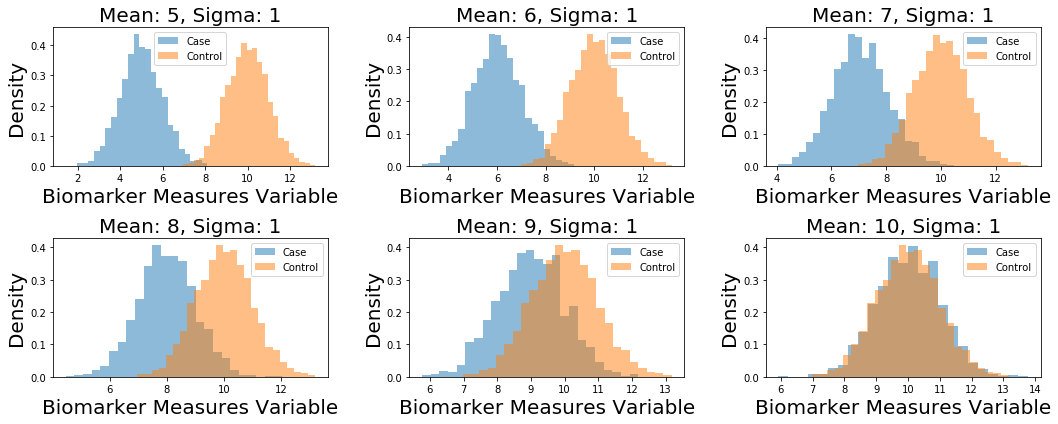

In [60]:
# define unique means
m1 = np.arange(5,11)
samples = {}.fromkeys(m1)

# define control distribution (this stays the same across 

n2 = np.random.normal(loc=10, scale=1, size=2000)

fig, (ax) = plt.subplots(2, 3, figsize=(15, 6))

for i, ax in enumerate(fig.axes):
    
    n1 = np.random.normal(loc=m1[i], scale=1, size=2000)
    samples[m1[i]] = n1

    ax.hist(n1, 25, alpha=0.5, label='Case', density=True,)
    ax.hist(n2, 25, alpha=0.5, label='Control', density=True,)
    ax.set_title('Mean: {:}, Sigma: 1'.format(m1[i]), fontsize=20)
    ax.set_xlabel('Biomarker Measures Variable', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.legend()
    
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/Example.Histograms.jpg')

### Generate plots of ROC for the samples generated above.

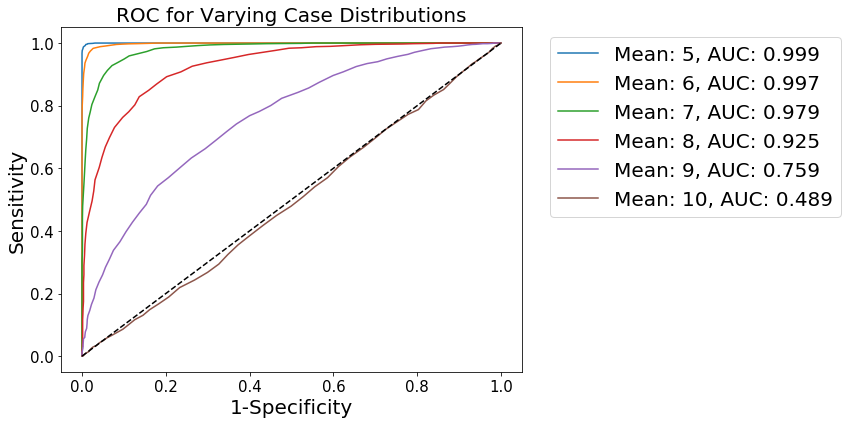

In [61]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
for mean, case_data in samples.items():
    
    [spec, sens] = roc(case_data, n2, 100, gte=True)
    A = auc(spec, sens)
    
    L = 'Mean: %i, AUC: %.3f' % (mean, A)
    plt.plot(1-np.asarray(spec), np.asarray(sens), label=L)
    plt.legend(bbox_to_anchor=(1.04,1), fontsize=20)
    plt.xlabel('1-Specificity', fontsize=20)
    plt.xticks(fontsize=15);
    plt.ylabel('Sensitivity', fontsize=20)
    plt.yticks(fontsize=15);
    
    plt.title('ROC for Varying Case Distributions', fontsize=20)
    
diag = np.asarray([[0, 0], [1, 1]])
plt.plot(diag[:, 0], diag[:, 1], linestyle='--', c='k')
plt.tight_layout()

plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/Example.ROC.Curves.jpg')

As the case and control distributions become more overlapped, they become harder to distinguish from one another.  The rates of false positives and true positives become more and more similar, so you get a more diagonal line -- when the means of the two distributions are the same, your case and control data comes from the same distributions, so you essentially can't distinguish the two groups.

### Let's test this idea with dose-response curves

I'm generating fake dose-response data.  

In [30]:
def sigmoid(beta, intercept, x):
    
    """
    Fake sigmoid function, takes in coefficient, shift, and dose values.
    
    Parameters:
    - - - - -
    beta: float
        slope
    intercept: float
        negative exponential intercept
    x: float, array
        data samples
        
    Returns:
    - - - -
    dose_response: float, array
        single-subject dose-response vector
        Between 0 and 1.
    """
    
    dose_resonse =  1 / (1 + np.exp(-beta*x + intercept))
    
    return dose_resonse

Let's sample 1000 cases and 1000 controls.  I'm sampling the slope coefficient values for the cases and controls from two different beta distributions.

$$
\beta_{control} \sim Beta(a=5, b=3) \\
\beta_{case} \sim Beta(a=10, b=2)
$$

while I'm sampling the negative exponential intercept parameter, $I$, from two different normal distributions.
$$
I_{control} \sim Normal(\mu=0, \sigma=1) \\
I_{case} \sim Normal(\mu=4, \sigma=1)
$$

such that the dose-response curve for individual, $k$, is generated as follows:

$$
DR = \frac{1}{1 + e^{-(\beta_{k}X) + I_{k}}} + min(X)
$$

where $\beta_{k}$ and $I_{k}$ are the slope and intercept values for the given subject, and $min(X)$ is the minimum dose value (which should be zero), which is added back to ensure the the dose curve actually starts at zero (i.e. no dose at first point).

### Sampling procedure of single-subject coefficients

In [66]:
# n cases and controls
S = 1000

# dictionary of slopes and intercept values for each subject
controls = {k: {'beta': None, 'intercept': None} for k in np.arange(S)}
cases = {k: {'beta': None, 'intercept': None} for k in np.arange(S)}

# get lists of betas and intercepts
beta_control = []
beta_case = []

intercept_control = []
intercept_case = []

for i in np.arange(S):
    
    controls[i]['beta'] = np.random.beta(a=5, b=3)
    controls[i]['intercept'] = np.random.normal(loc=0, scale=1)
    
    intercept_control.append(controls[i]['intercept'])
    beta_control.append(controls[i]['beta'])
    
    cases[i]['beta'] = np.random.beta(a=10, b=2)
    cases[i]['intercept'] = np.random.normal(loc=4, scale=1)
    
    intercept_case.append(cases[i]['intercept'])
    beta_case.append(cases[i]['beta'])

Histogram of the intercept values should show two different normal distributions

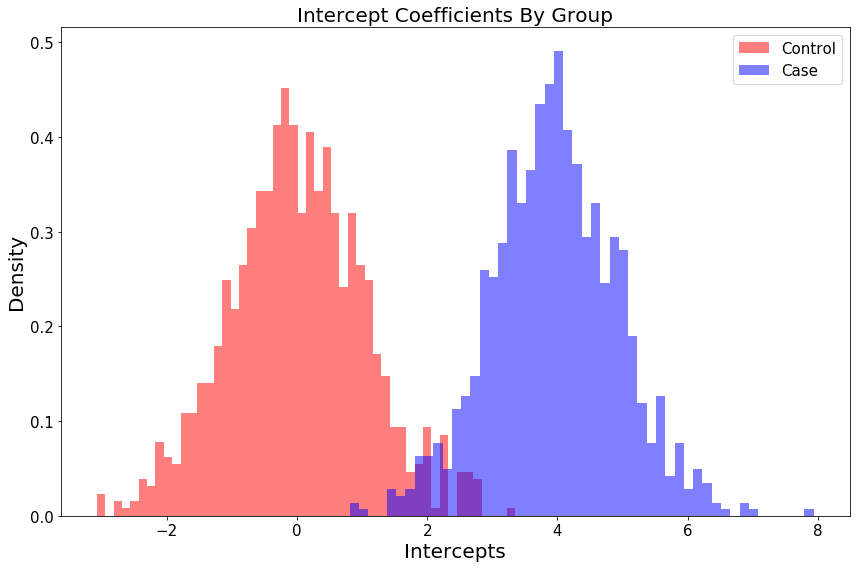

In [67]:
fig = plt.figure(figsize=(12, 8))
plt.hist(intercept_control, 50, color='r', alpha=0.5, density=True, label='Control');
plt.hist(intercept_case, 50, color='b', alpha=0.5, density=True, label='Case');
plt.ylabel('Density', fontsize=20);
plt.yticks(fontsize=15);

plt.xlabel('Intercepts', fontsize=20);
plt.xticks(fontsize=15);

plt.title('Intercept Coefficients By Group', fontsize=20);
plt.legend(fontsize=15);
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/DR.Intercepts.jpg')

Histogram of the slope values should show two different beta distributions.

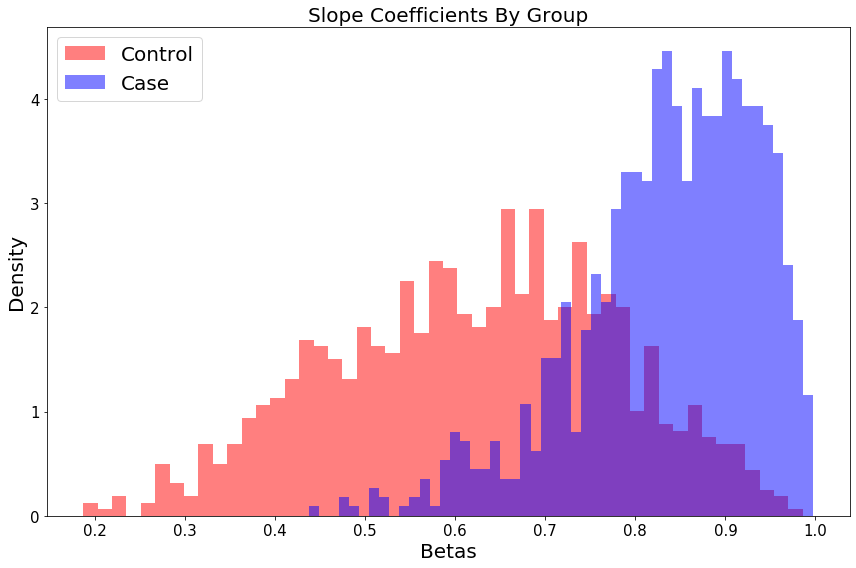

In [68]:
fig = plt.figure(figsize=(12, 8))
plt.hist(beta_control, 50, color='r', alpha=0.5, label='Control', density=True);
plt.hist(beta_case, 50, color='b', alpha=0.5, label='Case', density=True);
plt.ylabel('Density', fontsize=20);
plt.xlabel('Betas', fontsize=20);
plt.xticks(fontsize=15)

plt.title('Slope Coefficients By Group', fontsize=20);

plt.legend(fontsize=20);
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/DR.Slopes.jpg')

### Data-generating procedure for each subject

We're also computing the **lc50** for each subject, basically asking at what dose the dose-response curve = 0.5.

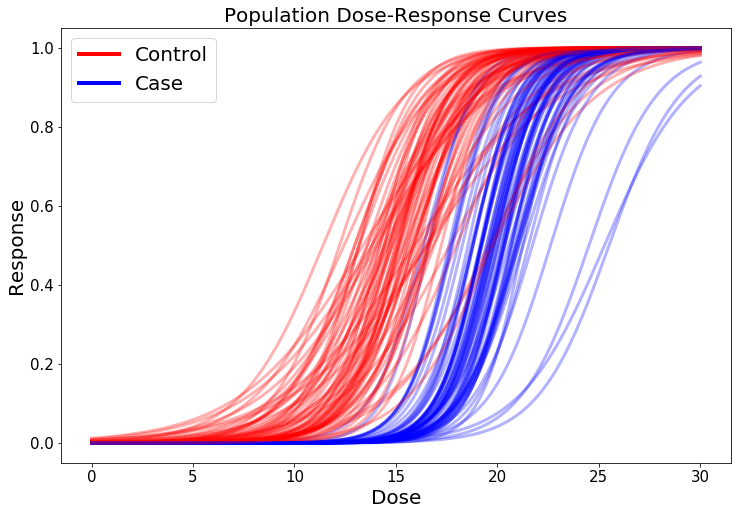

In [77]:
doses = np.linspace(-15,15,500)
dose_min = doses.min()

shifted_dose = doses + np.abs(dose_min)

fig, (ax1) = plt.subplots(figsize=(12, 8))

ec50_control = []
ec50_case = []

for c in np.arange(S):
    
    control_sample = sigmoid(controls[c]['beta'], controls[c]['intercept'], doses)
    case_sample = sigmoid(cases[c]['beta'], cases[c]['intercept'], doses)
    
    ec50_control.append(shifted_dose[control_sample < 0.5].max())
    ec50_case.append(shifted_dose[case_sample < 0.5].max())
    
    if (c % 15) == 0:
    
        ax1.plot(shifted_dose, control_sample, c='r', linewidth=3, alpha=0.3)
        ax1.plot(shifted_dose, case_sample, c='b', linewidth=3, alpha=0.3)
        
plt.legend({})
plt.title('Population Dose-Response Curves', fontsize=20);
plt.xlabel('Dose', fontsize=20);
plt.xticks(fontsize=15)
plt.ylabel('Response', fontsize=20);
plt.yticks(fontsize=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4)]
plt.legend(custom_lines, ['Control', 'Case'], fontsize=20);
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/DR.Curves.jpg')

Histogram of the **lc50** values for all subjects.  We can see clear differences in the case/control distributions.

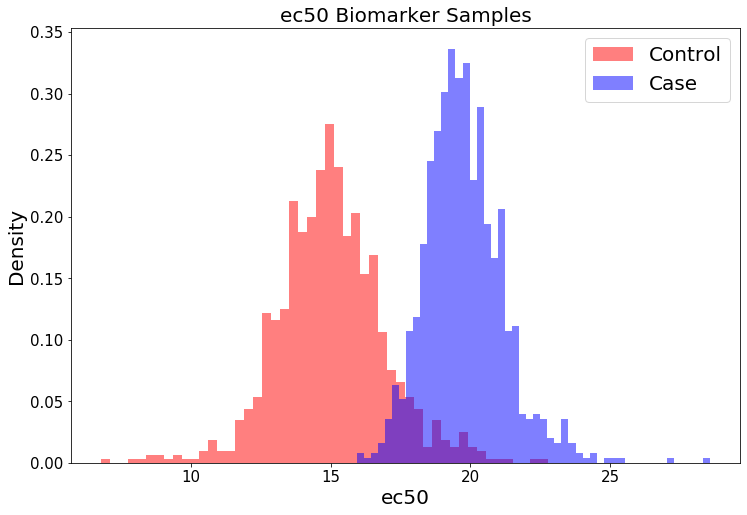

In [76]:
fig = plt.figure(figsize=(12, 8))
plt.hist(ec50_control, 50, color='r', alpha=0.5, label='Control', density=True);
plt.hist(ec50_case, 50, color='b', alpha=0.5, label='Case', density=True);
plt.legend(fontsize=20);

plt.xlabel('ec50', fontsize=20);
plt.xticks(fontsize=15);

plt.ylabel('Density', fontsize=20);
plt.yticks(fontsize=15);

plt.title('ec50 Biomarker Samples', fontsize=20)
plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/DR.ec50.jpg')

ROC curves for the **lc50** distributions

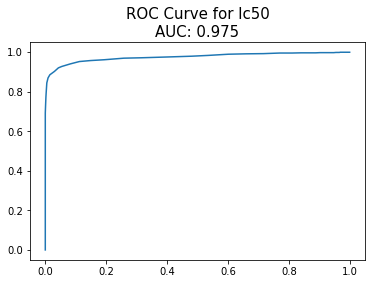

In [72]:
[spec, sens] = roc(ec50_case, ec50_control, 100, gte=False);
spec = np.asarray(spec)
sens = np.asarray(sens)
plt.plot(1-np.asarray(spec), sens);
plt.title('ROC Curve for lc50\nAUC: %.3f' %(auc(1-spec, sens)), fontsize=15);

Let's look at the ROC curves and AUC values for the full range of **lcX** values, where X will vary from 0.1 to 0.9, in increments of 0.1.

In [73]:
lc_doses = {k: {'control': np.zeros((S,)),
                'case': np.zeros((S, ))} for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

for lc in lc_doses.keys():
    
    for c in np.arange(S):
        
        control_sample = sigmoid(controls[c]['beta'], controls[c]['intercept'], doses)
        case_sample = sigmoid(cases[c]['beta'], cases[c]['intercept'], doses)
        
        ctr = shifted_dose[control_sample < lc]
        cse = shifted_dose[case_sample < lc]
        
        if ctr.shape[0] > 0:
            lc_doses[lc]['control'][c] = ctr.max()
        else:
            lc_doses[lc]['control'][c] = np.nan
            
        if cse.shape[0] > 0:
            lc_doses[lc]['case'][c] = cse.max()
        else:
            lc_doses[lc]['cae'][c] = np.nan
    

In [74]:
curves = {k: {'spec': None, 'sens': None} for k in lc_doses.keys()}
AUC = {k: None for k in lc_doses.keys()}

for lc in curves.keys():
    
    [spec, sens] = roc(lc_doses[lc]['case'], lc_doses[lc]['control'], 100, gte=False)
    spec = np.asarray(spec)
    sens = np.asarray(sens)
    
    curves[lc]['spec'] = spec
    curves[lc]['sens'] = sens
    
    AUC[lc] = auc(spec, sens)

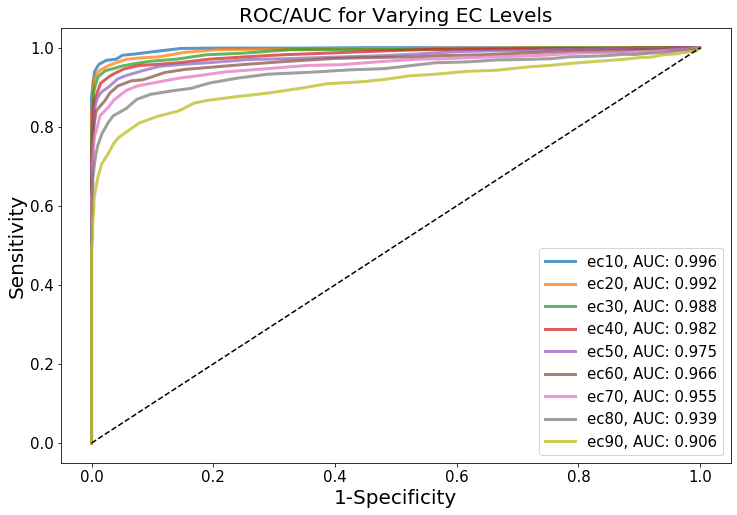

In [81]:
fig, (ax1) = plt.subplots(1,1, figsize=(12, 8))
for lc in curves.keys():
    
    plt.plot(1-curves[lc]['spec'], curves[lc]['sens'], linewidth=3,
             alpha=0.75, label='ec%i, AUC: %.3f' % (100*lc, AUC[lc]));

diag = np.asarray([[0, 0], [1, 1]])
plt.plot(diag[:, 0], diag[:, 1], linestyle='--', c='k')

plt.legend(fontsize=15);

plt.xlabel('1-Specificity', fontsize=20);
plt.xticks(fontsize=15);

plt.ylabel('Sensitivity', fontsize=20);
plt.yticks(fontsize=15);

plt.title('ROC/AUC for Varying EC Levels', fontsize=20);

plt.savefig('/Users/kristianeschenburg/Documents/Code/kristianeschenburg.github.io/figures/dose-response/DR.ecCurves.All.jpg')

In this case, the **lc10** curve shows the highest AUC, with a monotonically decreasing trend in AUC with **lc** value.  Not sure if this is what you had in mind, but you could showcase something like this.